In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from seaborn import utils
from seaborn.utils import (categorical_order, get_color_cycle, ci_to_errsize,
                    remove_na, locator_to_legend_entries)
from seaborn.algorithms import bootstrap
from seaborn.palettes import (color_palette, cubehelix_palette,
                       _parse_cubehelix_args, QUAL_PALETTES)
from seaborn.axisgrid import FacetGrid, _facet_docs

class LinePlotter_custom(sns.relational._RelationalPlotter):
    _legend_attributes = ["color", "linewidth", "marker", "dashes"]
    _legend_func = "plot"

    def __init__(self,
                 x=None, y=None, hue=None, size=None, style=None, data=None,
                 palette=None, hue_order=None, hue_norm=None,
                 sizes=None, size_order=None, size_norm=None,
                 dashes=None, markers=None, style_order=None,
                 units=None, estimator=None, ci=None, n_boot=None, seed=None,
                 sort=True, err_style=None, err_kws=None, legend=None):

        plot_data = self.establish_variables(
            x, y, hue, size, style, units, data
        )

        self._default_size_range = (
            np.r_[.5, 2] * mpl.rcParams["lines.linewidth"]
        )

        self.parse_hue(plot_data["hue"], palette, hue_order, hue_norm)
        self.parse_size(plot_data["size"], sizes, size_order, size_norm)
        self.parse_style(plot_data["style"], markers, dashes, style_order)

        self.units = units
        self.estimator = estimator
        self.ci = ci
        self.n_boot = n_boot
        self.seed = seed
        self.sort = sort
        self.err_style = err_style
        self.err_kws = {} if err_kws is None else err_kws

        self.legend = legend
    def aggregate(self, vals, grouper, units=None):
        """Compute an estimate and confidence interval using grouper."""
        func = self.estimator
        ci = self.ci
        n_boot = self.n_boot
        seed = self.seed

        # Define a "null" CI for when we only have one value
        null_ci = pd.Series(index=["low", "high"], dtype=np.float)

        # Function to bootstrap in the context of a pandas group by
        def bootstrapped_cis(vals):

            if len(vals) <= 1:
                return null_ci

            boots = bootstrap(vals, func=func, n_boot=n_boot, seed=seed)
            cis = utils.ci(boots, ci)
            return pd.Series(cis, ["low", "high"])

        # Group and get the aggregation estimate
        grouped = vals.groupby(grouper, sort=self.sort)
        est = grouped.agg(func)

        # Exit early if we don't want a confidence interval
        if ci is None:
            return est.index, est, None

        # Compute the error bar extents
        if ci == "sd":
            sd = grouped.std()
            cis = pd.DataFrame(np.c_[est - sd, est + sd],
                               index=est.index,
                               columns=["low", "high"]).stack()
        elif ci=='maxmin':
            cis = pd.DataFrame(np.c_[grouped.min(), grouped.max()],
                               index=est.index,
                               columns=["low", "high"]).stack()
        elif ci=='iqr':
            cis = pd.DataFrame(np.c_[grouped.quantile(0.25), grouped.quantile(0.75)],
                               index=est.index,
                               columns=["low", "high"]).stack()
        else:
            cis = grouped.apply(bootstrapped_cis)

        # Unpack the CIs into "wide" format for plotting
        if cis.notnull().any():
            cis = cis.unstack().reindex(est.index)
        else:
            cis = None

        return est.index, est, cis
    def plot(self, ax, kws):
        """Draw the plot onto an axes, passing matplotlib kwargs."""

        # Draw a test plot, using the passed in kwargs. The goal here is to
        # honor both (a) the current state of the plot cycler and (b) the
        # specified kwargs on all the lines we will draw, overriding when
        # relevant with the data semantics. Note that we won't cycle
        # internally; in other words, if ``hue`` is not used, all elements will
        # have the same color, but they will have the color that you would have
        # gotten from the corresponding matplotlib function, and calling the
        # function will advance the axes property cycle.

        scout, = ax.plot([], [], **kws)

        orig_color = kws.pop("color", scout.get_color())
        orig_marker = kws.pop("marker", scout.get_marker())
        orig_linewidth = kws.pop("linewidth",
                                 kws.pop("lw", scout.get_linewidth()))

        orig_dashes = kws.pop("dashes", "")

        kws.setdefault("markeredgewidth", kws.pop("mew", .75))
        kws.setdefault("markeredgecolor", kws.pop("mec", "w"))

        scout.remove()

        # Set default error kwargs
        err_kws = self.err_kws.copy()
        if self.err_style == "band":
            err_kws.setdefault("alpha", .2)
        elif self.err_style == "bars":
            pass
        elif self.err_style is not None:
            err = "`err_style` must be 'band' or 'bars', not {}"
            raise ValueError(err.format(self.err_style))

        # Loop over the semantic subsets and draw a line for each

        for semantics, data in self.subset_data():

            hue, size, style = semantics
            x, y, units = data["x"], data["y"], data.get("units", None)

            if self.estimator is not None:
                if self.units is not None:
                    err = "estimator must be None when specifying units"
                    raise ValueError(err)
                x, y, y_ci = self.aggregate(y, x, units)
            else:
                y_ci = None

            kws["color"] = self.palette.get(hue, orig_color)
            kws["dashes"] = self.dashes.get(style, orig_dashes)
            kws["marker"] = self.markers.get(style, orig_marker)
            kws["linewidth"] = self.sizes.get(size, orig_linewidth)

            line, = ax.plot([], [], **kws)
            line_color = line.get_color()
            line_alpha = line.get_alpha()
            line_capstyle = line.get_solid_capstyle()
            line.remove()

            # --- Draw the main line

            x, y = np.asarray(x), np.asarray(y)

            if self.units is None:
                line, = ax.plot(x, y, **kws)

            else:
                for u in units.unique():
                    rows = np.asarray(units == u)
                    ax.plot(x[rows], y[rows], **kws)

            # --- Draw the confidence intervals

            if y_ci is not None:

                low, high = np.asarray(y_ci["low"]), np.asarray(y_ci["high"])

                if self.err_style == "band":

                    ax.fill_between(x, low, high, color=line_color, **err_kws)

                elif self.err_style == "bars":

                    y_err = ci_to_errsize((low, high), y)
                    ebars = ax.errorbar(x, y, y_err, linestyle="",
                                        color=line_color, alpha=line_alpha,
                                        **err_kws)

                    # Set the capstyle properly on the error bars
                    for obj in ebars.get_children():
                        try:
                            obj.set_capstyle(line_capstyle)
                        except AttributeError:
                            # Does not exist on mpl < 2.2
                            pass

        # Finalize the axes details
        self.label_axes(ax)
        if self.legend:
            self.add_legend_data(ax)
            handles, _ = ax.get_legend_handles_labels()
            if handles:
                ax.legend()
                
sns.relational._LinePlotter=LinePlotter_custom

In [5]:
baseline=pd.read_csv('./model_outcomes'+'/baseline.csv')

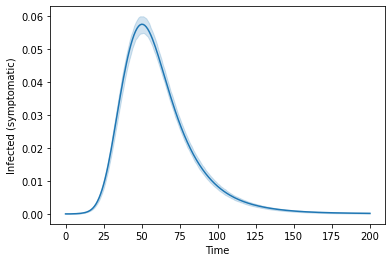

In [6]:
sns.lineplot(x="Time", y='Infected (symptomatic)',data=baseline)

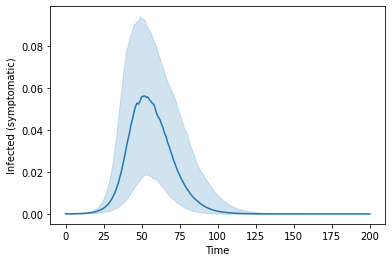

In [7]:
sns.lineplot(x="Time", y='Infected (symptomatic)',ci='iqr',estimator=np.median,data=baseline)

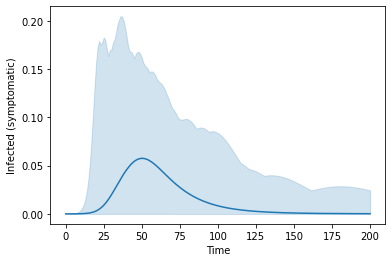

In [8]:
sns.lineplot(x="Time", y='Infected (symptomatic)',ci='maxmin',data=baseline)

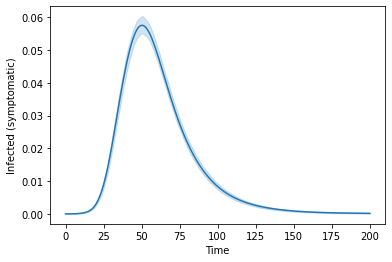

In [9]:
sns.lineplot(x="Time", y='Infected (symptomatic)',ci=95,data=baseline)

In [14]:
import numpy as np

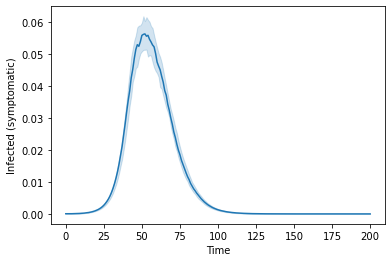

In [16]:
sns.lineplot(x="Time", y='Infected (symptomatic)',estimator=np.median,data=baseline)